In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision  # modules and transforms for computer vision
from matplotlib import pyplot as plt
from tqdm.auto import tqdm  # progress bar
import os
from glob import glob
import nibabel as nib
from torch.utils.data.dataset import Dataset
import random
import pathlib
import os
import math
from torch.utils.tensorboard import SummaryWriter
from skimage.metrics import structural_similarity as ssim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DataPath  = '/content/drive/Shareddrives/Deep Learning Project/'
ResultPath = '/content/drive/Shareddrives/Deep Learning Project/unet/'

Test Code(delete later)

In [1]:
# main_path= sorted(os.listdir(os.path.join(DataPath, 'train')))
# print(main_path)
# patient_paths = [os.path.join(DataPath, 'train', p) for p in main_path]
# # patient_paths=[]
# # for p in main_path:
# #   p=str(p)
# #   patient_paths.append(os.path.join(DataPath, 'train', p)) 
# print(patient_paths)
# t1_paths=[]
# for patient in patient_paths:
#   img_list=sorted(os.listdir(patient)) #List names of all images in patient folder
#   t1_paths.append(list(os.path.join(patient, x) for x in img_list if 'MPRAGE' in x and 'cropnpad' in x ))
# print(t1_paths)

In [ ]:
print(t1_paths[2][0])

/content/drive/Shareddrives/Deep Learning Project/train/11/MPRAGE_SAG_TI1400_0003_MPRAGE_SAG_TI1400_20191223072030_3_reg_clipped_n4corr_wmnorm_bet_cropnpad.nii.gz


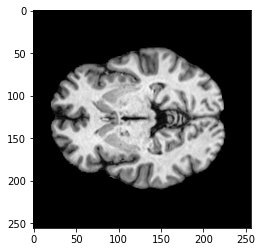

In [ ]:
#Plot Sample Images
t1_img = nib.load(t1_paths[2][0]).get_fdata().astype(np.float32) #256x256x256 3D image
plt.imshow(t1_img[:,:,100],cmap='gray')

## Loading Data

In [ ]:
from numpy.ma.core import floor
#Data Set Class 
class MRI_Dataset(Dataset):
    def __init__(self, dir, mode='train'):
        self.mode = mode #Define in train or test mode
        self.data_path=dir #Main directory for data

        self.t1_paths,self.t2_paths, self.fl_paths, self.label_paths = self._get_paths()
        #T1 paths is MPRAGE images
        #labels_paths is the WMn images (FGATIR)
        #Others are T2 and Flair

    def _get_paths(self):
        pat_ind= sorted(os.listdir(os.path.join(self.data_path, self.mode)))
        patient_paths = [os.path.join(self.data_path, self.mode, p) for p in pat_ind] #Acceses each patient's file (not numerically ordered)
        t1_paths=[]
        t2_paths=[] 
        fl_paths=[] 
        labels_paths=[]
        for patient in patient_paths:
          img_list=sorted(os.listdir(patient)) #List names of all images in patient folder
          t1_paths.append(list(os.path.join(patient, x) for x in img_list if 'MPRAGE' in x and 'cropnpad' in x ))
          t2_paths.append(list(os.path.join(patient, x) for x in img_list if '3DT2' in x and 'cropnpad' in x ))
          fl_paths.append(list(os.path.join(patient, x) for x in img_list if 'FLAIR' in x and 'cropnpad' in x )) 
          labels_paths.append(list(os.path.join(patient, x) for x in img_list if 'FGATIR' in x and 'cropnpad' in x )) #FGATIR Images are labels(WMn)

        return t1_paths,t2_paths ,fl_paths, labels_paths

    def __len__(self):
        #return len(self.t1_paths) #should we multiply this by 256
        return len(self.t1_paths*256) #multiply this by 256?

    def normalize(self, img):
        # normalize input intensities to 0--1
        max_val = np.percentile(img, 99.5)
        min_val = 0
        img = (img-min_val) / (max_val - min_val)
        return img
    
    def __getitem__(self, idx):
        #Extract all images plus labels for a single patient indicated by idx
        idx_i= math.floor(idx/256)
        t1_path = self.t1_paths[idx_i][0]
        t2_path = self.t2_paths[idx_i][0]
        fl_path = self.fl_paths[idx_i][0]
        label_path = self.label_paths[idx_i][0]

        #Load in the images
        t1_img = nib.load(t1_path).get_fdata().astype(np.float32) #256x256x256 3D image
        t1_img = torch.from_numpy(self.normalize(t1_img)) #normalize and convert to tensor
        t2_img = nib.load(t2_path).get_fdata().astype(np.float32)
        t2_img = torch.from_numpy(self.normalize(t2_img))
        fl_img = nib.load(fl_path).get_fdata().astype(np.float32)
        fl_img = torch.from_numpy(self.normalize(fl_img))
        label_img = nib.load(label_path).get_fdata().astype(np.float32)
        label_img = torch.from_numpy(label_img)
        #print(t1_img.shape)

        #Change images from 3D to 2D slices
        t1_img_2d = t1_img[:, :, (idx-(idx_i*256))]
        t2_img_2d = t2_img[:, :, (idx-(idx_i*256))]
        fl_img_2d = fl_img[:, :, (idx-(idx_i*256))]
        label_img_2d = label_img[:, :, (idx-(idx_i*256))]
        plt.imshow(t1_img_2d,cmap='gray')
        #print(t1_img_2d.shape)   
        #img = torch.stack([t1_img_2d, t2_img_2d, fl_img_2d], dim=-1).permute(3,0,1,2) #Channels x Height x Width x Slices #dim=-1 (slices dimension)?
        img = torch.stack([t1_img_2d, t2_img_2d, fl_img_2d], dim=-1).permute(2,0,1) #Channels x Height x Width x Slices #dim=-1 (slices dimension)?
        label = label_img_2d.unsqueeze(0)
        return img,label

In [ ]:
#Data Loaders
loader_train = torch.utils.data.DataLoader(
    dataset=MRI_Dataset(DataPath, 'train'),
    batch_size=1,
    shuffle=True)

loader_test = torch.utils.data.DataLoader(
    dataset=MRI_Dataset(DataPath, 'test'))


## U-Net Architecture

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_ch, out_ch, conditional_ch=0, num_lvs=4, base_ch=16, final_act='relu'):
    #def __init__(self, in_ch, out_ch, conditional_ch=0, num_lvs=4, base_ch=16, final_act='noact'):
        super().__init__()
        self.final_act = final_act
        self.in_conv = nn.Conv2d(in_ch, base_ch, 3, 1, 1)

        self.down_convs = nn.ModuleList()
        self.down_samples = nn.ModuleList()
        self.up_samples = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        for lv in range(num_lvs):
            ch = base_ch * (2 ** lv)
            self.down_convs.append(ConvBlock2d(ch + conditional_ch, ch * 2, ch * 2))
            self.down_samples.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.up_samples.append(Upsample(ch * 4))
            self.up_convs.append(ConvBlock2d(ch * 4, ch * 2, ch * 2))
        bottleneck_ch = base_ch * (2 ** num_lvs)
        self.bottleneck_conv = ConvBlock2d(bottleneck_ch, bottleneck_ch * 2, bottleneck_ch * 2)
        # self.out_conv = nn.Sequential(nn.Conv2d(base_ch * 2, base_ch, 3, 1, 1),
        #                               nn.LeakyReLU(0.1),
        #                               nn.Conv2d(base_ch, out_ch, 3, 1, 1))
        #
        # adding 2 more layers to the decoder to see if the prediction is less blurry
        self.out_conv = nn.Sequential(nn.Conv2d(base_ch * 2, base_ch, 3, 1, 1),
                                      nn.LeakyReLU(0.1),
                                      nn.Conv2d(base_ch, base_ch, 3, 1, 1),
                                      nn.LeakyReLU(0.1),
                                      nn.Conv2d(base_ch, base_ch, 3, 1, 1),
                                      nn.LeakyReLU(0.1),
                                      nn.Conv2d(base_ch, out_ch, 3, 1, 1))
        
    def forward(self, in_tensor, condition=None):
        encoded_features = []
        x = self.in_conv(in_tensor)
        for down_conv, down_sample in zip(self.down_convs, self.down_samples):
            if condition is not None:
                feature_dim = x.shape[-1]
                down_conv_out = down_conv(torch.cat([x, condition.repeat(1, 1, feature_dim, feature_dim)], dim=1))
            else:
                down_conv_out = down_conv(x)
            x = down_sample(down_conv_out)
            encoded_features.append(down_conv_out)
        x = self.bottleneck_conv(x)
        for encoded_feature, up_conv, up_sample in zip(reversed(encoded_features),
                                                       reversed(self.up_convs),
                                                       reversed(self.up_samples)):
            x = up_sample(x, encoded_feature)
            x = up_conv(x)
        x = self.out_conv(x)
        if self.final_act == 'sigmoid':
            x = torch.sigmoid(x)
        elif self.final_act == "relu":
            x = torch.relu(x)
        elif self.final_act == 'tanh':
            x = torch.tanh(x)
        else:
            x = x
        return x

class ConvBlock2d(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, 1, 1),
            nn.InstanceNorm2d(mid_ch),
            nn.LeakyReLU(0.1),
            nn.Conv2d(mid_ch, out_ch, 3, 1, 1),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(0.1)
        )

    def forward(self, in_tensor):
        return self.conv(in_tensor)


class Upsample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        out_ch = in_ch // 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(0.1)
        )

    def forward(self, in_tensor, encoded_feature):
        up_sampled_tensor = F.interpolate(in_tensor, size=None, scale_factor=2, mode='bilinear', align_corners=False)
        up_sampled_tensor = self.conv(up_sampled_tensor)
        return torch.cat([encoded_feature, up_sampled_tensor], dim=1)

Loss Functions

In [ ]:
class L1_loss(nn.Module):
    
    def __init__(self):
        super(L1_loss,self).__init__()

    def forward(self, inputs, targets):
        # need to only calculate this loss for pixels not equal to 0 to exclude background
        mask = targets > 0
        inputs_masked = inputs[mask]
        targets_masked = targets[mask]
        loss = torch.mean(torch.abs(inputs_masked - targets_masked))
        #loss = torch.mean(torch.abs(inputs - targets))
        return loss

class L2_loss(nn.Module):
    
    def __init__(self):
        super(L2_loss,self).__init__()

    def forward(self, inputs, targets):
        loss = torch.mean(torch.square(torch.abs(inputs - targets)))
        return loss

In [ ]:
#Make Directories to save results and model
def mkdir_p(path):
    import os
    import errno
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [ ]:
## Initilze Tensor Board - this is just a test, not sure if I am doing this right
#output_dir = '/content/drive/Shareddrives/Deep Learning Project/unet/runs/'
#writer = SummaryWriter(output_dir)
#%reload_ext tensorboard
#%tensorboard --logdir=runs


U-Net Training Class

In [ ]:
class Run_UNet:

    def __init__(self, in_ch, out_ch, out_dir, lr, pretrained_model=None, gpu=0):
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.out_dir = out_dir
        self.device = torch.device("cuda:0" if gpu==0 else "cuda:1")

        self.L1_loss = nn.L1Loss().to(self.device)
        #self.bce_loss = FocalLoss(gamma=2.0)
        self.L2_loss = nn.MSELoss().to(self.device)

        self.unet = UNet(in_ch=in_ch, out_ch=out_ch)
        #unet = UNet(2, 1, 3, 8, 128, 0)
        #self.unet = Wrapper(unet)
        self.optim_unet = torch.optim.Adam(self.unet.parameters(), lr=lr)
        self.start_epoch = 0
        self.unet.to(self.device)
        self.checkpoint = None
        if pretrained_model is not None:
            self.checkpoint = torch.load(pretrained_model, map_location=self.device)
            self.unet.load_state_dict(self.checkpoint['unet'])
            self.optim_unet.load_state_dict(self.checkpoint['optim_unet'])
            self.start_epoch = self.checkpoint['epoch']
        
        self.start_epoch += 1
        self.loss_store=[]
        #Make a function to save outputs in local directory 
        #mkdir_p(out_dir)
        mkdir_p(os.path.join(out_dir, 'results'))
        mkdir_p(os.path.join(out_dir, 'models'))

    def load_dataset(self, dir, batch_size):
        train_ds = MRI_Dataset(dir, 'train')
        # valid_ds = MRI_Dataset(t1_dir, fl_dir, label_dir, 'valid', whole_vol=True)
        self.train_loader=loader_train
        self.test_loader=loader_test
        # self.train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
        # self.valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=4)
        
    def train(self, epochs):
        for epoch in range(self.start_epoch, epochs+1):
            self.train_loader = tqdm(self.train_loader)
            self.unet.train()
            train_loss_sum = 0.0
            num_train_imgs = 0

            #for batch_id, img_dict in enumerate(self.train_loader):
            for batch_id, img_label in enumerate(self.train_loader):
                # img_patch = img_dict['img_patch'].to(self.device)
                # label_patch = img_dict['label_patch'].to(self.device)

                # label_pred = self.unet(img_patch)
                img,label=img_label
                img = img.to(self.device)
                label = label.to(self.device)

                #threshold to not train on background
                threshold = 0.25
                num_nonzero_pixels = torch.nonzero(label).size(0) # count the number of pixels with nonzero values
                #num_total_pixels = label.numel()                
                num_total_pixels = label.shape[0]*label.shape[1]
                if num_nonzero_pixels / num_total_pixels >= threshold:
                  label_pred = self.unet(img) #Unit
                

                  # calculate loss and update network weights
                  #Will need to train 2 different models for different loss functions
                  L1_loss = self.L1_loss(label_pred,label)
                  #L2_loss= self.L2_loss(label_pred,label)

                
                  self.optim_unet.zero_grad()
                  L1_loss.backward()
                  self.optim_unet.step()
                  # train_loss_sum += (dsc_loss + 0.0* bce_loss) * img_patch.shape[0]
                  # num_train_imgs += img_patch.shape[0]
                  self.train_loader.set_description((f'epoch: {epoch}; '
                                                     f'loss: {L1_loss:.3f};'))
                  # self.train_loader.set_description((f'epoch: {epoch}; '
                  #                                    f'dsc: {dsc_loss:.3f}; '
                  #                                    f'bce: {bce_loss:.3f}; '
                  #                                    f'seg: {train_loss_sum/num_train_imgs:.3f}; '))
                  n=130
                  slices=[]
                  for i in range(15):
                     slices.append(n+i*100)
                  if batch_id in slices:     
                      # save test results
                      img_affine = [[-1, 0, 0, 96], [0, -1, 0, 96], [0, 0, 1, -78], [0, 0, 0, 1]]
                      img_save = np.array((label_pred).detach().cpu().squeeze())
                      img_save = nib.Nifti1Image(img_save, img_affine)
                      file_name = os.path.join(self.out_dir, 'results', f'train_img_{str(epoch)}_{str(batch_id)}_pred.nii.gz')
                      nib.save(img_save, file_name)

                      img_save = np.array(label.detach().cpu().squeeze())
                      img_save = nib.Nifti1Image(img_save, img_affine)
                      file_name = os.path.join(self.out_dir, 'results', f'train_img_{str(epoch)}_{str(batch_id)}_gt.nii.gz')
                      nib.save(img_save, file_name)
                else:
                  continue 
            #writer.add_scalar('visualize loss',
            #      L1_loss,
            #      (epochs-1) * 18*256 + batch_id)
            # save models 
            file_name = os.path.join(self.out_dir, 'models',
                                     f'epoch{str(epoch).zfill(3)}.pt')
            self.save_model(file_name, epoch)
    def test(self): #Saves 2D slices (130th slice from each patient)
        # Testing
        self.test_loader = tqdm(self.test_loader)
        self.unet.eval()
        test_loss_sum = 0.0
        num_test_imgs = 0
        with torch.set_grad_enabled(False):
            n=130
            slices=[]
            for i in range(3):
              slices.append(n+i*256)
            for batch_id, img_label in enumerate(self.test_loader):
                  
              img,label=img_label
              img = img.to(self.device)
              label = label.to(self.device)

              label_pred = self.unet(img) #Unit

              L1_loss = self.L1_loss(label_pred,label)
              self.test_loader.set_description((f'loss: {L1_loss:.3f};'))     
                    
              if batch_id in slices:     
                # save test results
                img_affine = [[-1, 0, 0, 96], [0, -1, 0, 96], [0, 0, 1, -78], [0, 0, 0, 1]]
                img_save = np.array((label_pred).detach().cpu().squeeze())
                img_save = nib.Nifti1Image(img_save, img_affine)
                file_name = os.path.join(self.out_dir, 'results', f'test_img{str(batch_id)}_pred.nii.gz')
                nib.save(img_save, file_name)

                img_save = np.array(label.detach().cpu().squeeze())
                img_save = nib.Nifti1Image(img_save, img_affine)
                file_name = os.path.join(self.out_dir, 'results', f'valid_epoch{str(batch_id)}_gt.nii.gz')
                nib.save(img_save, file_name)

    def save_3d(self,flag): # Calculates Test Loss Values and saves 3D Volumes of the test set (3 volumes) for fully trained model
        #If flag is True, saves 3D volume predictions (only on last epoch)
        
        self.test_loader = tqdm(self.test_loader)
        self.unet.eval()
        with torch.set_grad_enabled(False):
            predictions=[]
            gt=[]
            for batch_id, img_label in enumerate(self.test_loader):
                
              img,label=img_label
              img = img.to(self.device)
              label = label.to(self.device)

              label_pred = self.unet(img) 
              predictions.append(label_pred)
              gt.append(label)

              L1_loss = self.L1_loss(label_pred,label)
              self.test_loader.set_description((f'loss: {L1_loss:.3f};'))     
              self.loss_store.append(L1_loss)

              end_id = [255, 511, 767]
              #if batch_id % 255 ==0 and batch_id != 0 and flag == True :
              if batch_id in end_id and flag == True :
                print(batch_id)
                pred_3D=np.zeros(((256,256,256)))
                gt_3D=np.zeros(((256,256,256)))
                for i in range(256):
                  pred=predictions[i]  
                  ground=gt[i] 
                  pred_3D[:,:,i]=pred.cpu()
                  gt_3D[:,:,i]=ground.cpu()
               
                #Apply affine transform to each 3D image 
                img_affine = [[-1, 0, 0, 96], [0, -1, 0, 96], [0, 0, 1, -78], [0, 0, 0, 1]]
                #img_save = np.array((pred_3D).detach().cpu().squeeze())
                img_save=pred_3D.squeeze()
                img_save = nib.Nifti1Image(img_save, img_affine)  
                #gt_save = np.array(gt_3D.detach().cpu().squeeze())
                gt_save=gt_3D.squeeze()
                gt_save = nib.Nifti1Image(gt_save, img_affine)
                
                #Save 3D Volumes
                file_name = os.path.join(self.out_dir, 'results/3D', f'test_{str(batch_id)}_pred3D.nii.gz')
                nib.save(img_save, file_name)
                file_name = os.path.join(self.out_dir, 'results/3D', f'test_{str(batch_id)}_gt3D.nii.gz')
                nib.save(gt_save, file_name)
                
                predictions=[] #Reset predictions list
                gt=[]


    def save_model(self, file_name, epoch):
        state = {'epoch' : epoch,
                 'loss': L1_loss,
                 'unet' : self.unet.state_dict(),
                 'optim_unet' : self.optim_unet.state_dict()}
        torch.save(obj=state, f=file_name)

In [2]:
#Set model parameters
lr=3e-4
batch_size=1
epochs=10
gpu=0
out_dir= ResultPath 

# initialize model
trainer = Run_UNet(
        in_ch = 3,
        out_ch = 1,
        out_dir = out_dir,
        lr = lr,
        pretrained_model = None,
        gpu = gpu)

trainer.load_dataset(dir=DataPath,
        batch_size = batch_size)

trainer.train(epochs = epochs)

In [ ]:
#Load Pretrained Model
file = ResultPath+"models/epoch010.pt"
model= UNet(in_ch = 3,out_ch = 1)
#model.load_state_dict(torch.load(file))

checkpoint = torch.load(file) # ie, model_best.pth.tar
model.load_state_dict(checkpoint['unet'])


<All keys matched successfully>

In [3]:
# Save Predictions For Test Set 
lr=3e-4
batch_size=1
epochs=10
gpu=0
out_dir= ResultPath 
tester = Run_UNet(
        in_ch = 3,
        out_ch = 1,
        out_dir = out_dir,
        lr = lr,
        pretrained_model = file,
        gpu = gpu)
tester.load_dataset(dir=DataPath,
        batch_size = batch_size)

tester.test()

In [4]:
#Save 3D synthesis results from Test Set
lr=3e-4
batch_size=1
epochs=10
gpu=0
out_dir= ResultPath 
tester3D = Run_UNet(
        in_ch = 3,
        out_ch = 1,
        out_dir = out_dir,
        lr = lr,
        pretrained_model = file,
        gpu = gpu)
tester3D.load_dataset(dir=DataPath,
        batch_size = batch_size)

tester3D.save_3d(flag==True)

In [ ]:
#Calculating the Testing Loss Across Epochs
lr=3e-4
batch_size=1
epochs=10
gpu=0
out_dir= ResultPath
for model in range(1:11):
  #Load Pretrained Model
  if i != 10:
    file = ResultPath+"models/epoch00"+str(i)+".pt" 
  else:
    file = ResultPath+"models/epoch0"+str(i)+".pt" 
  tester3D_loss = Run_UNet(
          in_ch = 3,
          out_ch = 1,
          out_dir = out_dir,
          lr = lr,
          pretrained_model = file,
          gpu = gpu)
  tester3D_loss.load_dataset(dir=DataPath,
          batch_size = batch_size)

  tester3D_loss.save_3d(flag==False)

## Data Analysis

In [ ]:
# MAE, MSE, SSIM, PSNR

def mse(input,targets):
  mse_loss = np.mean(np.square(np.abs(input - targets)))
  return mse_loss

def mae(input,targets):
  mae_loss = np.mean(np.abs(input - targets))
  return mae_loss

from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
def ssim(synthetic_img,reference_img):
  s_loss = structural_similarity(reference_img, synthetic_img)
  #psnr_val = peak_signal_noise_ratio(reference_img, synthetic_img, data_range=reference_img.max() - reference_img.min())

def psnr(input,targets):
  max_pixel = 1
  p_loss = 20*np.log10(max_pixel / np.sqrt(mse(input,targets)))
  return p_loss

In [ ]:
#Calculate Metrics on 3D Images
list=[255,511,767]
#list=[256,512]
mse_list=[]
mae_list=[]
ssim_list=[]
psnr_list=[]

for i in range(3):
  filename=ResultPath+'results/3D_L1_wbackground/'
  pred=filename+"test_"+str(list[i])+"_pred3D.nii.gz"
  gt=filename+"test_"+str(list[i])+"_gt3D.nii.gz"
  test_image=nib.load(pred).get_fdata().astype(np.float32)
  test_gt=nib.load(gt).get_fdata().astype(np.float32)
  mse_loss=mse(test_image,test_gt)
  mae_loss=mae(test_image,test_gt)
  s_loss=structural_similarity(test_gt,test_image)
  #print(s_loss)
  p_loss=psnr(test_image,test_gt)
  mse_list.append(mse_loss)
  mae_list.append(mae_loss)
  ssim_list.append(s_loss)
  psnr_list.append(p_loss)
avg_mse=np.mean(mse_list)
avg_mae=np.mean(mae_list)
avg_ssim=np.mean(ssim_list)
avg_psnr=np.mean(psnr_list)
mse_list.append(avg_mse)
mae_list.append(avg_mae)
ssim_list.append(avg_ssim)
psnr_list.append(avg_psnr)

data={'MSE':mse_list,'MAE':mae_list,"PSNR":psnr_list,"SSIM":ssim_list}
#df=pd.DataFrame(data, index=['Patient 1','Patient 2','Patient 3','Average'])
df=pd.DataFrame(data, index=['Patient 1','Patient 2','Average'])
display(df)

,MSE,MAE,PSNR,SSIM
Patient 1,0.000903,0.008971,30.443048,0.977916
Patient 2,0.000652,0.007937,31.859541,0.985316
Average,0.000777,0.008454,31.151294,0.981616
